In [2]:
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_sample = pd.read_csv("../dataset_creation/df_sample_with_features.csv")

In [4]:
def parse_embedding(x):
    if isinstance(x, str):
        x = x.strip()
        x = x.replace("[", "").replace("]", "")
        return np.array(
            [float(v) for v in x.split()],
            dtype=np.float32
        )
    return np.array(x, dtype=np.float32)
df_sample["embedding"] = df_sample["embedding"].apply(parse_embedding)

In [5]:
embeddings = df_sample['embedding'].to_list()

In [6]:
from sklearn.preprocessing import StandardScaler
embeddings_scaled = StandardScaler().fit_transform(embeddings)

In [75]:
dbscan = DBSCAN(
    eps=0.5,
    min_samples=100,
    metric="cosine"  # IMPORTANT for embeddings
)

clusters = dbscan.fit_predict(embeddings)

In [56]:
import umap

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

embeddings_2d = umap_model.fit_transform(embeddings)

d:\NLP\.nlp\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [57]:
df_vis = df_sample.copy()  # or df_scope / df_filtered

df_vis["x"] = embeddings_2d[:, 0]
df_vis["y"] = embeddings_2d[:, 1]

In [10]:
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

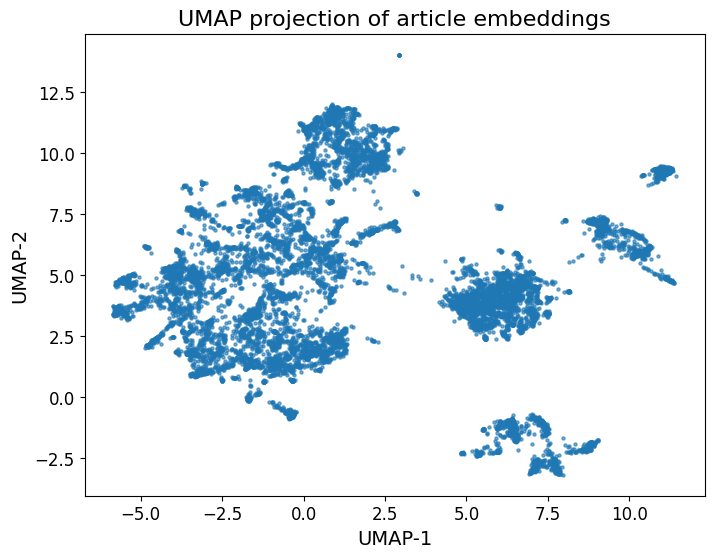

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(df_vis["x"], df_vis["y"], s=5, alpha=0.6)
plt.title("UMAP projection of article embeddings")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

plt.show()

In [76]:
df_vis["dbscan_cluster"] = clusters

In [77]:
labels, counts = np.unique(clusters, return_counts=True)
dict(zip(labels, counts))

{np.int64(-1): np.int64(4630),
 np.int64(0): np.int64(6138),
 np.int64(1): np.int64(1143),
 np.int64(2): np.int64(89)}

In [78]:
len(labels)

4

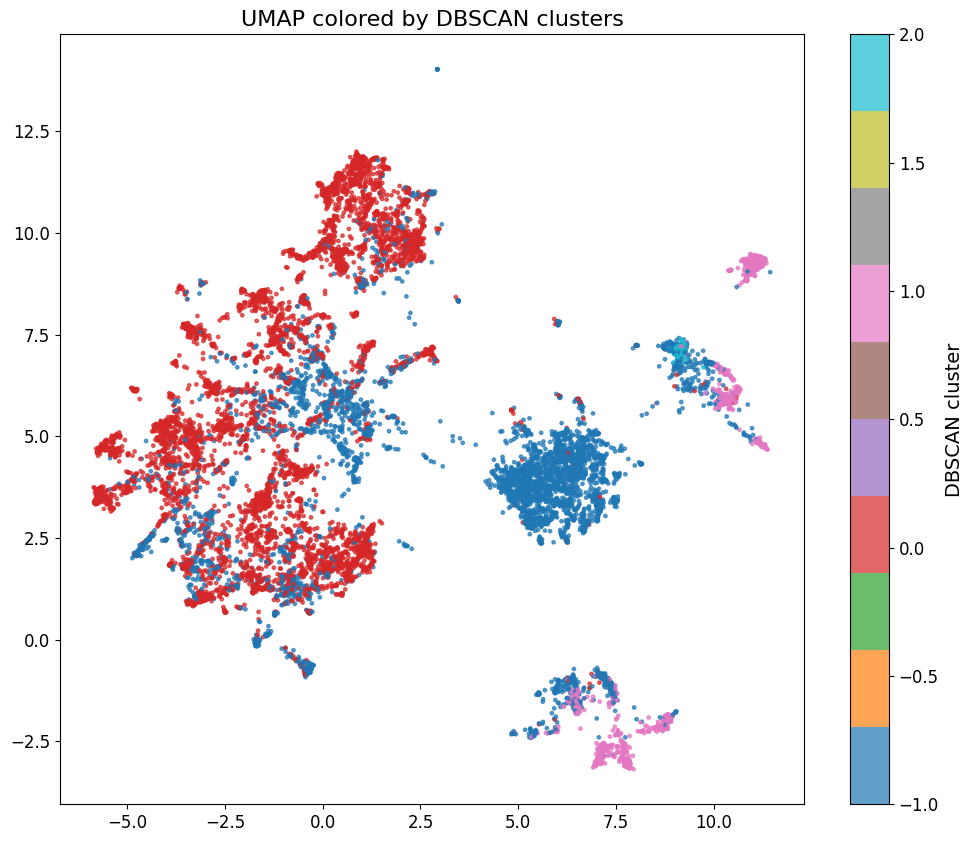

In [79]:
plt.figure(figsize=(12, 10))
plt.scatter(
    df_vis["x"],
    df_vis["y"],
    c=df_vis["dbscan_cluster"],
    cmap="tab10",
    s=6,
    alpha=0.7
)
plt.colorbar(label="DBSCAN cluster")
plt.title("UMAP colored by DBSCAN clusters")
plt.show()

In [81]:
clusterer = HDBSCAN(
    min_cluster_size=30,   # try 20–50
    min_samples=10,
    metric="cosine"
)

In [82]:
clusters = clusterer.fit_predict(embeddings)
df_sample["cluster_id"] = clusters

In [86]:
labels, counts = np.unique(clusters, return_counts=True)
dict(zip(labels, counts))

{np.int64(-1): np.int64(7646),
 np.int64(0): np.int64(35),
 np.int64(1): np.int64(30),
 np.int64(2): np.int64(70),
 np.int64(3): np.int64(165),
 np.int64(4): np.int64(53),
 np.int64(5): np.int64(43),
 np.int64(6): np.int64(76),
 np.int64(7): np.int64(65),
 np.int64(8): np.int64(51),
 np.int64(9): np.int64(191),
 np.int64(10): np.int64(3517),
 np.int64(11): np.int64(58)}

In [87]:
df_vis['hbscan_cluster'] = df_sample["cluster_id"]

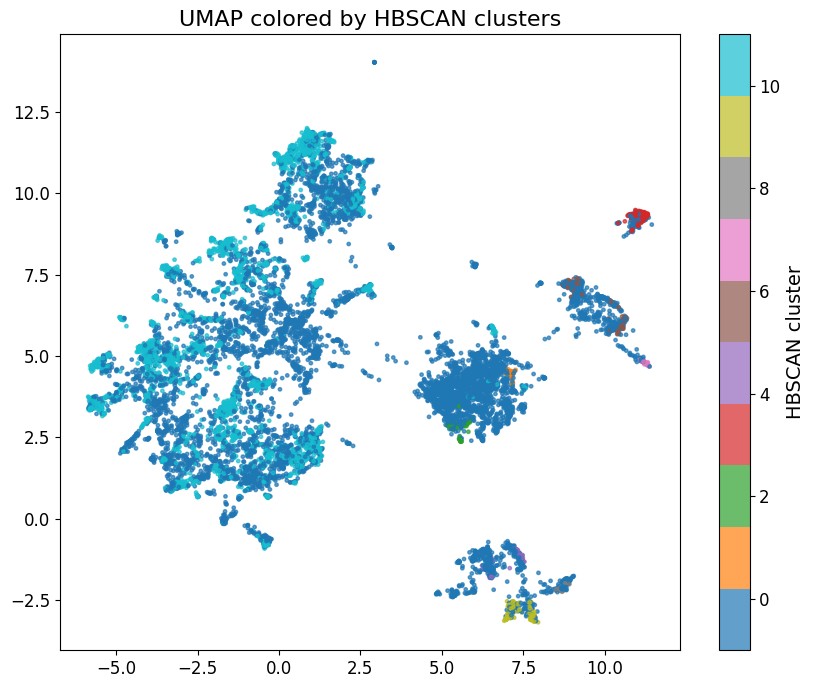

In [90]:
plt.figure(figsize=(10, 8))
plt.scatter(
    df_vis["x"],
    df_vis["y"],
    c=df_vis["hbscan_cluster"],
    cmap="tab10",
    s=6,
    alpha=0.7
)
plt.colorbar(label="HBSCAN cluster")
plt.title("UMAP colored by HBSCAN clusters")

plt.savefig(
    "hbscan_umap.png",
    dpi=300,
    transparent=True
)

plt.show()

In [21]:
from sklearn.preprocessing import normalize
embeddings_norm = normalize(embeddings)

In [22]:
from sklearn.cluster import KMeans

k = 6  # start here

kmeans = KMeans(
    n_clusters=k,
    random_state=42,
    n_init=20
)

clusters = kmeans.fit_predict(embeddings_norm)

In [23]:
df_vis['clusters'] = clusters

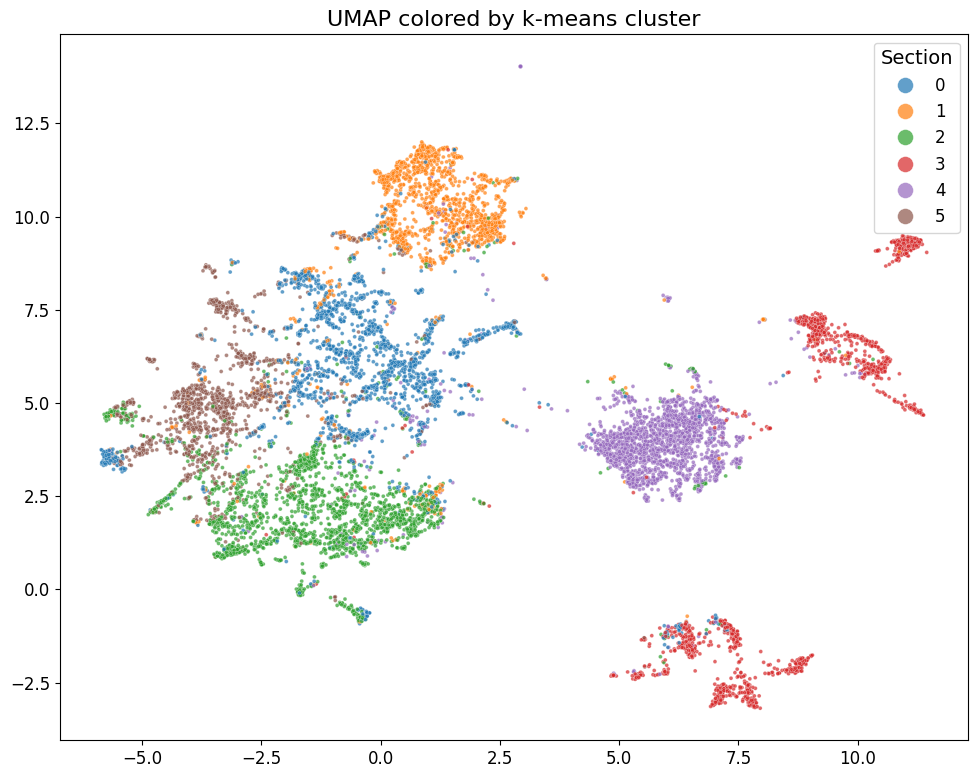

In [24]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_vis,
    x="x",
    y="y",
    hue="clusters",
    palette="tab10",   # discrete colors
    s=8,
    alpha=0.7
)
plt.xlabel("")
plt.ylabel("")
plt.title("UMAP colored by k-means cluster")
plt.legend(title="Section", markerscale=4)

plt.tight_layout()

plt.savefig(
    "umap_kmean_6.png",
    dpi=300,
    transparent=True
)

plt.show()


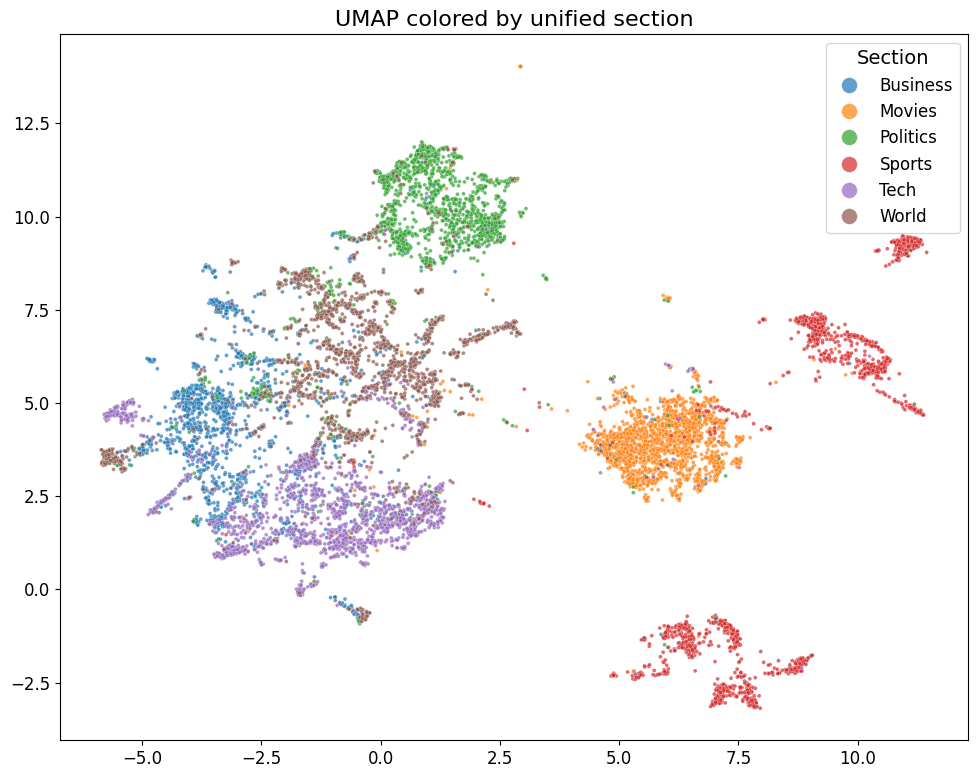

In [25]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_vis,
    x="x",
    y="y",
    hue="section_unified",
    palette="tab10",   # discrete colors
    s=8,
    alpha=0.7
)
plt.xlabel("")
plt.ylabel("")
plt.title("UMAP colored by unified section")
plt.legend(title="Section", markerscale=4)

plt.tight_layout()

plt.savefig(
    "umap_unified.png",
    dpi=300,
    transparent=True
)

plt.show()

In [26]:
y_true = df_vis["section_unified"]
y_pred = df_vis["clusters"]


In [27]:
y_pred

0        5
1        2
2        2
3        5
4        5
        ..
11995    0
11996    0
11997    0
11998    0
11999    1
Name: clusters, Length: 12000, dtype: int32

In [28]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")

ARI: 0.643
NMI: 0.648


In [29]:
def purity_score(y_true, y_pred):
    contingency = pd.crosstab(y_true, y_pred)
    return np.sum(np.max(contingency.values, axis=0)) / np.sum(contingency.values)

purity = purity_score(y_true, y_pred)
print(f"Cluster Purity: {purity:.3f}")

Cluster Purity: 0.822


In [ ]:
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(embeddings, y_pred, metric="euclidean")
print(f"Silhouette Score: {silhouette:.3f}")


Silhouette Score: 0.048


In [31]:
results = pd.DataFrame({
    "Metric": ["ARI", "NMI", "Purity", "Silhouette"],
    "Value": [ari, nmi, purity, silhouette]
})

results

,Metric,Value
0,ARI,0.642522
1,NMI,0.648228
2,Purity,0.821917
3,Silhouette,0.048412


In [32]:
df_sample[clusters==4]['section_unified'].value_counts()

section_unified
Movies      1944
Sports        66
Tech          48
World         35
Politics      33
Business      11
Name: count, dtype: int64

In [69]:
Ks = range(2, 30)
sil_scores = []

for k in Ks:
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(embeddings)
    sil = silhouette_score(embeddings, labels)
    sil_scores.append(sil)

sil_scores

[0.053509969264268875,
 0.04435175657272339,
 0.03780833259224892,
 0.03786062076687813,
 0.04846355319023132,
 0.04323269799351692,
 0.04703223332762718,
 0.04665645211935043,
 0.043124984949827194,
 0.042193297296762466,
 0.04268207773566246,
 0.0452287495136261,
 0.04104148969054222,
 0.04192750155925751,
 0.04134704917669296,
 0.04049351066350937,
 0.040517713874578476,
 0.03910059854388237,
 0.04015748202800751,
 0.03796982020139694,
 0.03983648493885994,
 0.03940948098897934,
 0.040901925414800644,
 0.04180721938610077,
 0.042752958834171295,
 0.044005412608385086,
 0.04322405904531479,
 0.044864729046821594]

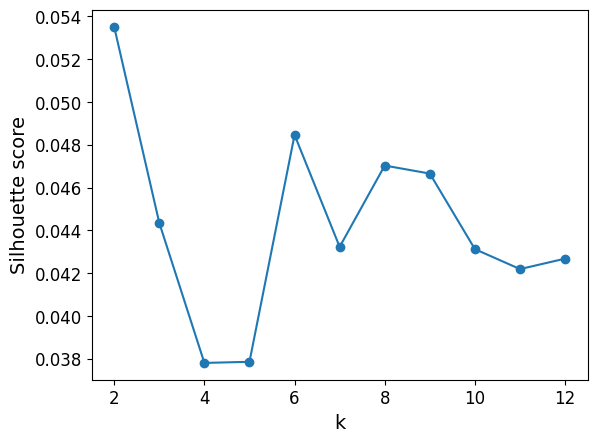

In [52]:
plt.plot(Ks, sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")

plt.savefig(
    "sil_kmeans.png",
    dpi=300,
    transparent=True
)

plt.show()

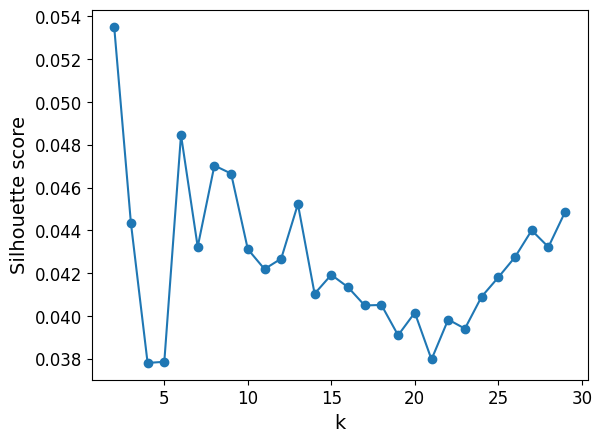

In [70]:
plt.plot(Ks, sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette score")

plt.savefig(
    "sil_kmeans.png",
    dpi=300,
    transparent=True
)

plt.show()

## DBSCAN

In [63]:
from sklearn.neighbors import NearestNeighbors

k = 10

nn = NearestNeighbors(n_neighbors=k, metric="euclidean")
nn.fit(embeddings)

distances, _ = nn.kneighbors(embeddings)

# Take distance to k-th nearest neighbor
k_distances = distances[:, -1]

# Sort for plotting
k_distances_sorted = np.sort(k_distances)


In [35]:
X_narr = df_sample[
    ["sentiment_value", "subjective", "bias_value", "frame_id"]
].values.astype(float)

In [36]:
X_narr = df_sample[
    ["sentiment_value", "subjective", "bias_value", "frame_id"]
].values.astype(float)

In [37]:
scaler = StandardScaler()
X_narr_scaled = scaler.fit_transform(X_narr)

In [38]:
alpha = 0.2
X_fused = np.hstack([
    embeddings,
    alpha * X_narr_scaled
])


In [39]:
kmeans_fused = KMeans(n_clusters=6, random_state=42)
labels_fused = kmeans_fused.fit_predict(X_fused)

df_vis["kmeans_fused"] = labels_fused

In [40]:
embeddings_2d = umap_model.fit_transform(X_fused)

In [41]:
df_vis["x"] = embeddings_2d[:, 0]
df_vis["y"] = embeddings_2d[:, 1]

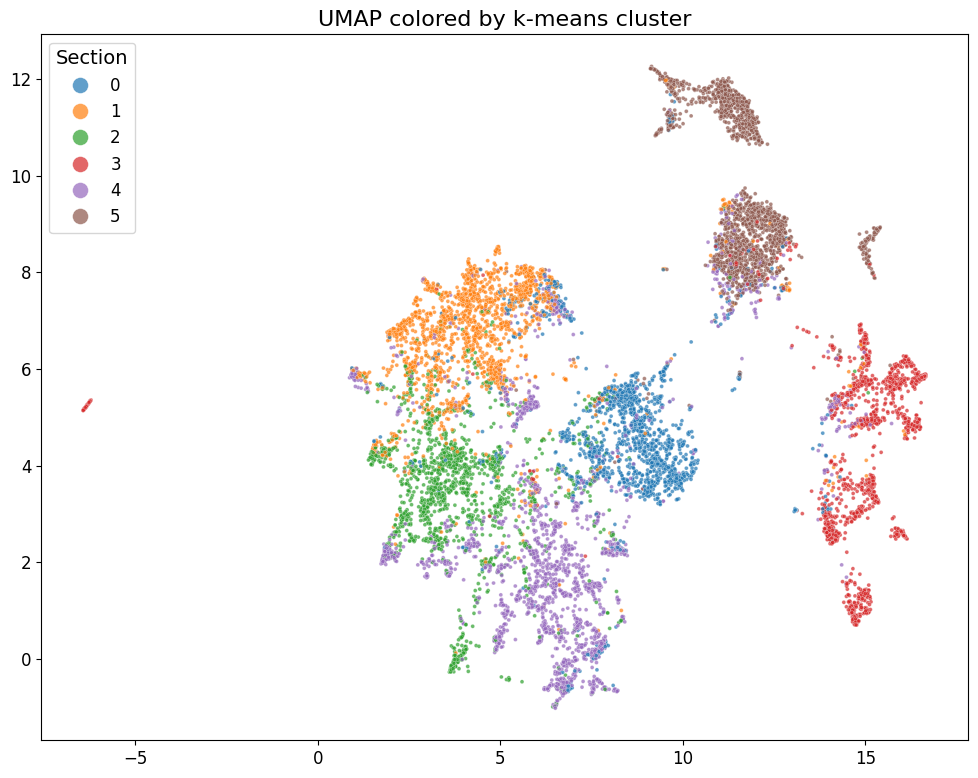

In [42]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_vis,
    x="x",
    y="y",
    hue="kmeans_fused",
    palette="tab10",   # discrete colors
    s=8,
    alpha=0.7
)
plt.xlabel("")
plt.ylabel("")
plt.title("UMAP colored by k-means cluster")
plt.legend(title="Section", markerscale=4)

plt.tight_layout()

plt.savefig(
    "umap_kmean_6_fused.png",
    dpi=300,
    transparent=True
)

plt.show()

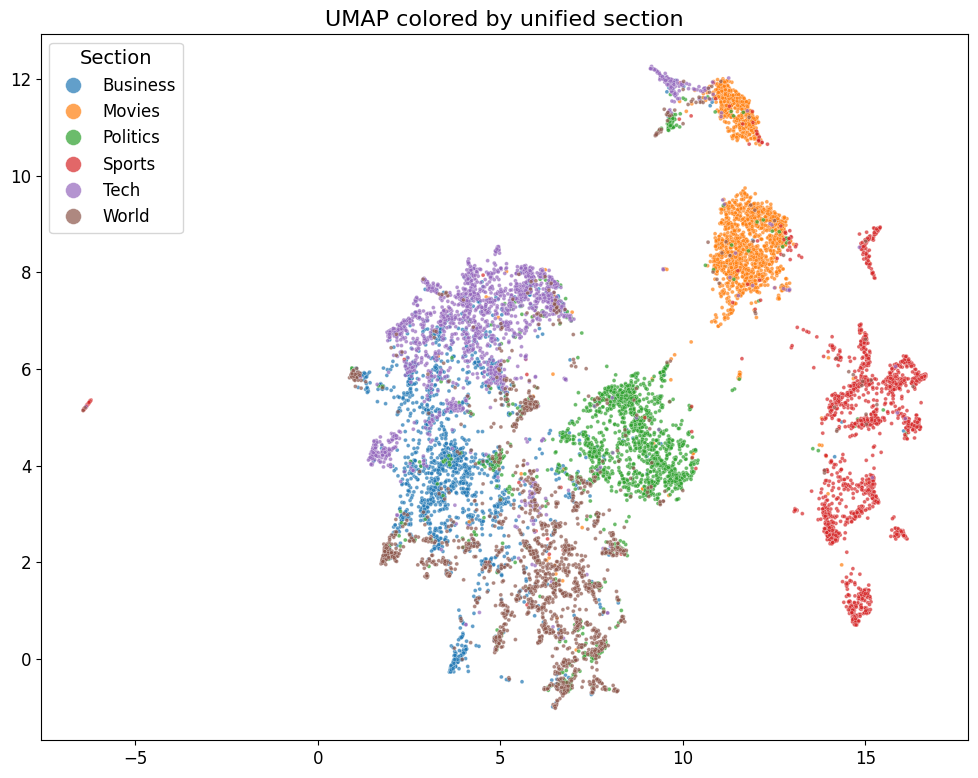

In [43]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_vis,
    x="x",
    y="y",
    hue="section_unified",
    palette="tab10",   # discrete colors
    s=8,
    alpha=0.7
)
plt.xlabel("")
plt.ylabel("")
plt.title("UMAP colored by unified section")
plt.legend(title="Section", markerscale=4)

plt.tight_layout()

plt.savefig(
    "umap_unified_fused.png",
    dpi=300,
    transparent=True
)

plt.show()

In [44]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")

ARI: 0.643
NMI: 0.648


In [45]:
ari_change = adjusted_rand_score(
    df_vis["clusters"],
    df_vis["kmeans_fused"]
)
nmi_change = normalized_mutual_info_score(
    df_vis["clusters"],
    df_vis["kmeans_fused"]
)

In [47]:
ari_change

0.6901479513366929

In [49]:
print(ari_change)
print(nmi_change)

0.6901479513366929
0.6797513643550163


In [48]:
ari_fused = adjusted_rand_score(
    df_sample["section_unified"],
    df_vis["kmeans_fused"]
)
nmi_fused = normalized_mutual_info_score(
    df_sample["section_unified"],
    df_vis["kmeans_fused"]
)
print(f"ARI: {ari_fused:.3f}")
print(f"NMI: {nmi_fused:.3f}")

purity_fused = purity_score(
    df_sample["section_unified"],
    df_vis["kmeans_fused"]
)
print(f"Cluster Purity: {purity:.3f}")

silhouette_fused = silhouette_score(embeddings, df_vis["kmeans_fused"], metric="euclidean")
print(f"Silhouette Score: {silhouette:.3f}")

ARI: 0.517
NMI: 0.527
Cluster Purity: 0.822
Silhouette Score: 0.048


In [ ]:
ari = adjusted_rand_score(y_true, y_pred)
nmi = normalized_mutual_info_score(y_true, y_pred)

print(f"ARI: {ari:.3f}")
print(f"NMI: {nmi:.3f}")

In [152]:
df_sample.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'date', 'year', 'month', 'day', 'author',
       'title', 'article', 'url', 'section', 'publication', 'length',
       'section_clean', 'section_unified', 'discourse_text', 'sentiment_label',
       'sentiment_score', 'bias_label', 'bias_score', 'subjectivity_label',
       'subjectivity_score', 'frame', 'frame_score', 'sentiment_value',
       'subjective', 'bias_value', 'frame_id', 'embedding', 'cluster_id',
       'kmeans_fused'],
      dtype='object')

In [151]:
narrative_cols = [
    "sentiment_value",
    "subjective",
    "bias_value",
    "frame_id"
]

df_sample[narrative_cols].describe()

,sentiment_value,subjective,bias_value,frame_id
count,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.355917,0.086917,0.994167,0.762667
std,0.805374,0.281725,0.076156,1.060943
min,-1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,5.000000


In [153]:
for col in narrative_cols:
    print(f"\n{col}")
    print(df_sample[col].value_counts(normalize=True))



sentiment_value
sentiment_value
 1    0.565583
 0    0.224750
-1    0.209667
Name: proportion, dtype: float64

subjective
subjective
0    0.913083
1    0.086917
Name: proportion, dtype: float64

bias_value
bias_value
1    0.994167
0    0.005833
Name: proportion, dtype: float64

frame_id
frame_id
0    0.582000
1    0.175250
2    0.163917
3    0.058333
4    0.017917
5    0.002583
Name: proportion, dtype: float64


## Final experimnet narratives intra topic

In [140]:
numeric_features = [
    "sentiment_value",
    "subjective",
    "bias_value"
]

section_variance_numeric = (
    df_sample
    .groupby("section_unified")[numeric_features]
    .var()
)
section_variance_numeric["mean_numeric_variance"] = (
    section_variance_numeric.mean(axis=1)
)

In [141]:
def frame_entropy(x):
    p = x.value_counts(normalize=True)
    return -(p * np.log(p + 1e-9)).sum()

section_frame_entropy = (
    df_sample
    .groupby("section_unified")["frame_id"]
    .apply(frame_entropy)
    .rename("frame_entropy")
)

In [173]:
section_narrative_summary = section_variance_numeric.join(
    section_frame_entropy
)

section_narrative_summary

,sentiment_value,subjective,bias_value,mean_numeric_variance,frame_entropy
section_unified,,,,,
Business,0.575636,0.014782,0.000000,0.196806,1.096355
Movies,0.908552,0.204520,0.002992,0.372022,1.068751
Politics,0.405350,0.043906,0.001997,0.150418,0.812951
Sports,0.753865,0.077398,0.027702,0.286322,0.998689
Tech,0.737773,0.063840,0.000500,0.267371,1.277682
World,0.330745,0.020569,0.000999,0.117438,0.817951


In [177]:
target_section = section_narrative_summary["mean_numeric_variance"].idxmax()
print("Selected section:", target_section)

Selected section: Movies


In [178]:
#target_section = "Sports"

In [179]:
df_topic = df_sample[
    df_sample["section_unified"] == target_section
].copy()

len(df_topic)

2000

In [180]:
X_topic = np.vstack(df_topic["embedding"].values)

In [181]:
k_topic = 3  # small, interpretable
kmeans_topic = KMeans(n_clusters=k_topic, random_state=42)

df_topic["topic_cluster"] = kmeans_topic.fit_predict(X_topic)

In [182]:
df_topic["topic_cluster"]

2000    0
2001    0
2002    2
2003    1
2004    2
       ..
3995    2
3996    1
3997    0
3998    2
3999    1
Name: topic_cluster, Length: 2000, dtype: int32

In [183]:
k_topic = 3  # small, interpretable
kmeans_topic = KMeans(n_clusters=k_topic, random_state=42)

df_topic["topic_cluster"] = kmeans_topic.fit_predict(X_topic)

In [184]:
df_topic["topic_cluster"].value_counts()

topic_cluster
1    846
0    608
2    546
Name: count, dtype: int64

In [192]:
cluster_profiles = (
    df_topic
    .groupby("topic_cluster")[numeric_features]
    .var()
)

cluster_profiles


,sentiment_value,subjective,bias_value
topic_cluster,,,
0,0.893772,0.204619,0.004918
1,0.869351,0.232434,0.001182
2,0.949276,0.136684,0.003656


In [195]:
pd.crosstab(
    df_topic["topic_cluster"],
    df_topic["frame_id"],
    normalize="index"
)

frame_id,0,1,2,3,4,5
topic_cluster,,,,,,
0,0.501645,0.042763,0.381579,0.064145,0.004934,0.004934
1,0.503546,0.085106,0.368794,0.034279,0.000000,0.008274
2,0.443223,0.005495,0.468864,0.078755,0.000000,0.003663


In [186]:
pd.crosstab(
    df_topic["topic_cluster"],
    df_topic["sentiment_value"],
    normalize="index"
)

sentiment_value,-1,0,1
topic_cluster,,,
0,0.422697,0.105263,0.472039
1,0.359338,0.098109,0.542553
2,0.510989,0.047619,0.441392


In [197]:
frame_dist = pd.crosstab(
    df_topic["topic_cluster"],
    df_topic["frame_id"],
    normalize="index"
)
frame_dist


frame_id,0,1,2,3,4,5
topic_cluster,,,,,,
0,0.501645,0.042763,0.381579,0.064145,0.004934,0.004934
1,0.503546,0.085106,0.368794,0.034279,0.000000,0.008274
2,0.443223,0.005495,0.468864,0.078755,0.000000,0.003663


In [198]:
sentiment_dist = pd.crosstab(
    df_topic["topic_cluster"],
    df_topic["sentiment_value"],
    normalize="index"
)

sentiment_dist


sentiment_value,-1,0,1
topic_cluster,,,
0,0.422697,0.105263,0.472039
1,0.359338,0.098109,0.542553
2,0.510989,0.047619,0.441392


In [199]:
subjectivity_dist = pd.crosstab(
    df_topic["topic_cluster"],
    df_topic["subjective"],
    normalize="index"
)

subjectivity_dist


subjective,0,1
topic_cluster,,
0,0.713816,0.286184
1,0.633570,0.366430
2,0.836996,0.163004


In [200]:
bias_dist = pd.crosstab(
    df_topic["topic_cluster"],
    df_topic["bias_value"],
    normalize="index"
)

bias_dist


bias_value,0,1
topic_cluster,,
0,0.004934,0.995066
1,0.001182,0.998818
2,0.003663,0.996337


In [201]:
from scipy.spatial.distance import jensenshannon

def js_divergence(table):
    clusters = table.index
    out = {}
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            out[(clusters[i], clusters[j])] = jensenshannon(
                table.loc[clusters[i]],
                table.loc[clusters[j]]
            )
    return out


In [204]:
js_framing = js_divergence(frame_dist)
js_sentiment = js_divergence(sentiment_dist)
js_subjectivity = js_divergence(subjectivity_dist)
js_bias = js_divergence(bias_dist)

js_framing, js_sentiment, js_subjectivity, js_bias

({(np.int32(0), np.int32(1)): np.float64(0.08861772276500877),
  (np.int32(0), np.int32(2)): np.float64(0.1159722064405917),
  (np.int32(1), np.int32(2)): np.float64(0.1730545200195243)},
 {(np.int32(0), np.int32(1)): np.float64(0.05073279053701212),
  (np.int32(0), np.int32(2)): np.float64(0.08898234174112388),
  (np.int32(1), np.int32(2)): np.float64(0.11708950129004747)},
 {(np.int32(0), np.int32(1)): np.float64(0.060568499556946154),
  (np.int32(0), np.int32(2)): np.float64(0.104893875383252),
  (np.int32(1), np.int32(2)): np.float64(0.16465198159512937)},
 {(np.int32(0), np.int32(1)): np.float64(0.024903983385206094),
  (np.int32(0), np.int32(2)): np.float64(0.006882340948575997),
  (np.int32(1), np.int32(2)): np.float64(0.018274469763854433)})

In [203]:
js_framing

{(np.int32(0), np.int32(1)): np.float64(0.08861772276500877),
 (np.int32(0), np.int32(2)): np.float64(0.1159722064405917),
 (np.int32(1), np.int32(2)): np.float64(0.1730545200195243)}

In [187]:
df_topic.head()

,Unnamed: 0.1,Unnamed: 0,date,year,month,day,author,title,article,url,...,subjectivity_score,frame,frame_score,sentiment_value,subjective,bias_value,frame_id,embedding,cluster_id,topic_cluster
2000,790221,790221,2019-01-09 10:15:00,2019,1.0,9,Maura Hohman,"Claire Foy on Difficult Childhood, Anxiety",Claire Foy is a mainstay at awards shows these...,https://people.com/movies/claire-foy-talks-anx...,...,0.955680,economic consequences,0.396335,1,0,1,1,"[-0.0029177894, -0.01088949, 0.0054748324, 0.0...",-1,0
2001,769776,769776,2019-05-31 16:03:00,2019,5.0,31,Alexia Fernandez,Dolly Parton Says She Expects Production to Be...,Dolly Parton’s going back to the 9 to 5! The s...,https://people.com/movies/dolly-parton-9-to-5-...,...,0.586355,human interest,0.324693,-1,0,1,2,"[-0.121095225, -0.14631355, 0.112143785, -0.02...",-1,0
2002,2386502,2398866,2019-10-28 19:08:00,2019,10.0,28,Joelle Goldstein,Ben Affleck Not 'Involved with Anyone' Amid Ou...,"Ben Affleck is not in a serious relationship, ...",https://people.com/movies/ben-affleck-not-seri...,...,0.985669,conflict,0.243013,1,0,1,0,"[-0.023035051, -0.0057374034, -0.01968857, -0....",-1,2
2003,712914,712914,2019-05-30 13:38:00,2019,5.0,30,Maria Pasquini,Boy George Calls Upcoming Biopic About His Lif...,Boy George is the latest pop icon to get the f...,https://people.com/movies/boy-george-upcoming-...,...,0.883565,conflict,0.260502,1,0,1,0,"[-0.046862293, 0.00038510616, 0.008973503, -0....",-1,1
2004,2288085,2300449,2019-09-19 10:05:00,2019,9.0,19,Dave Quinn,Brad Pitt Isn’t Sure What to Make of Twitter’s...,"Three decades into his Hollywood career, Brad ...",https://people.com/movies/brad-pitt-twitter-th...,...,0.649847,conflict,0.468359,0,1,1,0,"[-0.02004698, 0.038222898, 0.023355104, 0.0188...",-1,2


In [188]:
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)

X_umap_topic = umap_model.fit_transform(X_topic)

d:\NLP\.nlp\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


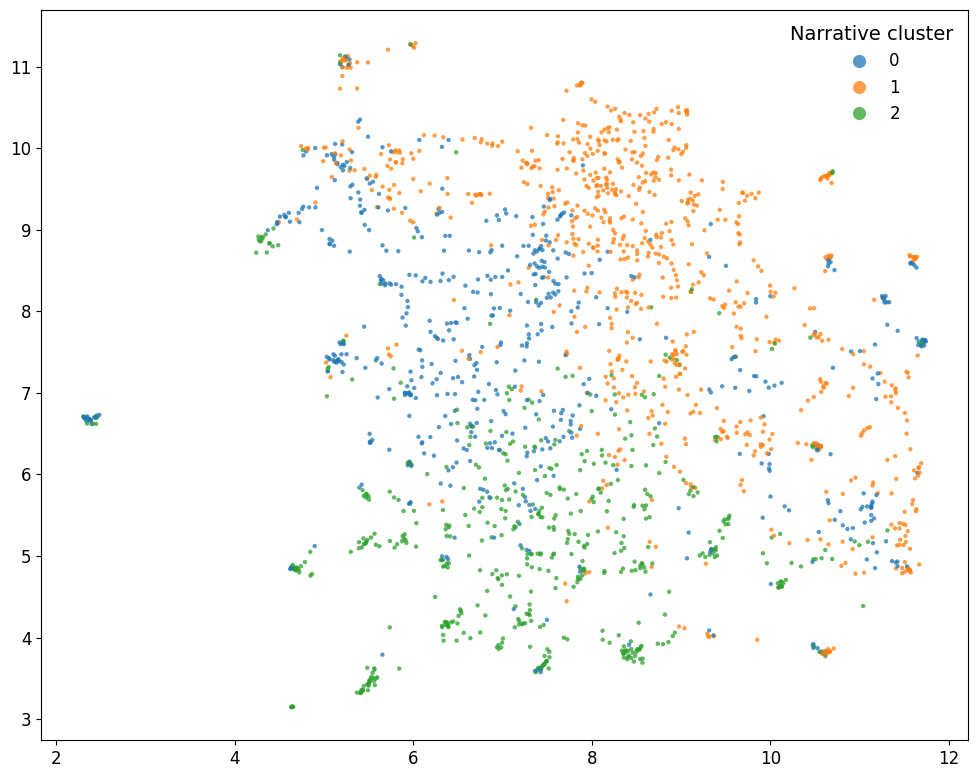

In [189]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_umap_topic[:, 0],
    y=X_umap_topic[:, 1],
    hue=df_topic["topic_cluster"],
    palette="tab10",
    s=10,
    alpha=0.75,
    linewidth=0
)

plt.xlabel("")
plt.ylabel("")
plt.legend(
    title="Narrative cluster",
    markerscale=3,
    frameon=False
)
plt.tight_layout()

plt.savefig(
    "umap_kmean_6.png",
    dpi=300,
    transparent=True
)

plt.show()

In [171]:
from scipy.stats import zscore

z = zscore(df_topic[features])
df_z = pd.DataFrame(z, columns=features)
df_z["topic_cluster"] = df_topic["topic_cluster"].values

df_z.groupby("topic_cluster").mean()


,sentiment_value,subjective,bias_value,frame_id
topic_cluster,,,,
0,0.118241,-0.035189,-0.415881,-0.001298
1,-0.060035,-0.116702,0.073159,0.052561
2,0.026318,0.188414,0.108676,-0.075980


In [191]:
var_before = df_topic[features].var().mean()
var_after = df_topic.groupby("topic_cluster")[features].var().mean()

var_before, var_after


(np.float64(0.5829658579289644),
 sentiment_value    0.904133
 subjective         0.191246
 bias_value         0.003252
 frame_id           1.218127
 dtype: float64)

In [113]:
pd.crosstab(
    df_topic["topic_cluster"],
    df_topic["frame_id"],
    normalize="index"
)

frame_id,0,1,2,3,4,5
topic_cluster,,,,,,
0,0.501645,0.042763,0.381579,0.064145,0.004934,0.004934
1,0.503546,0.085106,0.368794,0.034279,0.000000,0.008274
2,0.443223,0.005495,0.468864,0.078755,0.000000,0.003663
